In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Model for four conduits meeting at a junction and merging into one
from scipy.integrate import odeint
from scipy.optimize import brentq

# Constants - unchanging
rho_w = 1000.#density of water, kg/m^3
rho_i = 900#density of ice, kg/m^3
L_f = 3.34e5#Latent heat of fusion (ice), J/kg
n=3.#ice flow law exponent, unitless
B=5.8e7#Arrhenius parameter, N/m^2 *s^(1/n)
f=0.1#Darcy-Weisbach friction factor, unitless
g = 9.8#gravitational accel, m^2/s
P = 24.*3600. # Period - 1 day in seconds

In [5]:
# Functions
def R(ti,Ri):
    P=24.*3600.
    return Ri*(1.+sin(2.*pi*ti/P)/2.)

def P_wet(A):
    return 2.*sqrt(pi*A)#2.*A**2./pi
def D_H(A):
    return 4.*A/P_wet(A)

def C(A,L):
    return A*sqrt(2.*g/(1+f*L/D_H(A)))

# calculate head for three conduits
def fhf(hf, h1, C1,C2,C3,C4,C_merg):
    #flow conservation at junction, used to calculate hf via minimization
    return C1*sqrt(abs(h1-hf))*sign(h1-hf) + C2*sqrt(abs(h1-hf))*sign(h1-hf) + C3*sqrt(abs(h1-hf))*sign(h1-hf) + C4*sqrt(abs(h1-hf))*sign(h1-hf) - C_merg*sqrt(hf)

# three conduits
def dy_dt4(y,ti,Recharge,Zi):
    Pi = rho_i*g*Zi
    h1 = y[0]
    A1 = y[1]
    A2 = y[2]
    A3 = y[3]
    A4 = y[4]
    A_merg = y[5]
    C1 = C(A1,L1)
    C2 = C(A2,L2)
    C3 = C(A3,L3)
    C4 = C(A4,L4)
    C_merg = C(A_merg,L_merg)
    hf = brentq(fhf, 0,10000, args=(h1,C1,C2,C3,C4,C_merg))
    #print h1,hf
    Q1 = C1*sqrt(abs(h1-hf))*sign(h1-hf)
    Q2 = C2*sqrt(abs(h1-hf))*sign(h1-hf)
    Q3 = C3*sqrt(abs(h1-hf))*sign(h1-hf)
    Q4 = C4*sqrt(abs(h1-hf))*sign(h1-hf)
    Q_merg = C_merg*sqrt(abs(hf))
    P = 24.*3600.
    dh1_dt = (Recharge*(1.+sin(2.*pi*ti/P)/2.) - Q1 - Q2 - Q3 -Q4)/A_R
    Pw1 = rho_w*g*(h1+hf)/2.
    Pw2 = rho_w*g*(h1+hf)/2.
    Pw3 = rho_w*g*(h1+hf)/2.
    Pw4 = rho_w*g*(h1+hf)/2.
    Pw_merg = rho_w*g*(hf)
    dA1_dt = f*rho_w/(8*rho_i*L_f)*P_wet(A1)*(abs(Q1)/A1)**3 - 2.*(1./(n*B))**n*A1*(Pi-Pw1)*abs(Pi-Pw1)**(n-1.)
    dA2_dt = f*rho_w/(8*rho_i*L_f)*P_wet(A2)*(abs(Q2)/A2)**3 - 2.*(1./(n*B))**n*A2*(Pi-Pw2)*abs(Pi-Pw2)**(n-1.)
    dA3_dt = f*rho_w/(8*rho_i*L_f)*P_wet(A3)*(abs(Q3)/A3)**3 - 2.*(1./(n*B))**n*A3*(Pi-Pw3)*abs(Pi-Pw3)**(n-1.)
    dA4_dt = f*rho_w/(8*rho_i*L_f)*P_wet(A4)*(abs(Q4)/A4)**3 - 2.*(1./(n*B))**n*A4*(Pi-Pw4)*abs(Pi-Pw4)**(n-1.)
    dAmerg_dt = f*rho_w/(8*rho_i*L_f)*P_wet(A_merg)*(abs(Q_merg)/A_merg)**3 - 2.*(1./(n*B))**n*A_merg*(Pi-Pw_merg)*abs(Pi-Pw_merg)**(n-1.)
    return [dh1_dt, dA1_dt, dA2_dt, dA3_dt, dA4_dt, dAmerg_dt]




Max Head = 911.665652239 Min Head = 593.542785379
Average Recharge = 1.0 Moulin Area = 100 Ice thickness = 1000


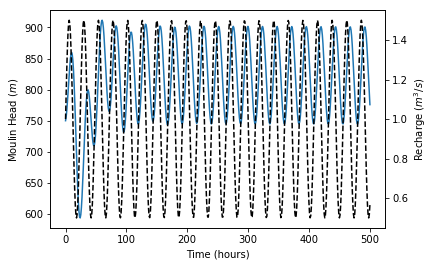

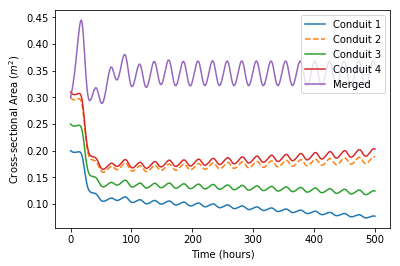

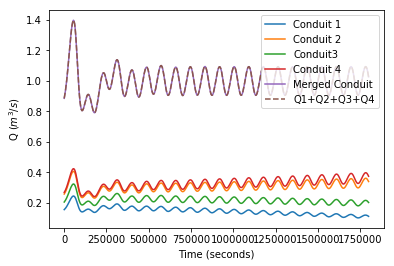

In [8]:
# Investigating: minimum hydraulic diameter neccessary
# Changing:

# Clear variables that change
# Changing ---- 3 conduit below --------
L1=5000 # Length of conduit 1
L2=5000 # Length of conduit 2
L3=5000 # Length of conduit 3
L4=5000
L_merg=10000 # Length of merged conduit
A0_1=0.2 # Starting Ac of conduit 1
A0_2=0.3 # Starting Ac of conduit 2
A0_3=0.25 # Starting Ac of conduit 3
A0_4=0.31
A0_merg=0.3 # Starting Ac of merged conduit
h0=750 # head in moulin (start)
Recharge=1.0 # Average recharge to moulin
A_R=100 # Moulin cross sectional area
Z=1000 # Ice thickness


# Run model with above specification
nhours = 500
nsecs = nhours*60*60
t = linspace(0,nsecs,500)

sol4= odeint(dy_dt4, [h0,A0_1,A0_2,A0_3,A0_4,A0_merg], t, args=(Recharge,Z))

Rec = Recharge*(1.+sin(2.*pi*t/P)/2.) #define recharge for plotting

hmax1=max(sol4[:,0])

# print model run specifications
print 'Max Head =',hmax1, 'Min Head =',min(sol4[:,0])
print 'Average Recharge =',Recharge,'Moulin Area =',A_R,'Ice thickness =',Z


# Plotting above version of the model
tplot=t/3600.
fig, ax1 = subplots()
ax2 = ax1.twinx()
ax1.plot(tplot,sol4[:,0])
ax2.plot(tplot,Rec,'k--')
ax1.set_xlabel("Time (hours)")
ax1.set_ylabel("Moulin Head ($m$)")
ax2.set_ylabel("Recharge ($m^3/s$)")


figure()
plot(tplot,sol4[:,1])
plot(tplot,sol4[:,2],'--')
plot(tplot,sol4[:,3])
plot(tplot,sol4[:,4])
plot(tplot,sol4[:,5])
xlabel("Time (hours)")
ylabel("Cross-sectional Area ($m^2$)")
legend(['Conduit 1','Conduit 2','Conduit 3','Conduit 4','Merged'],loc=1)

# CHECK -----
C1 = C(sol4[:,1],L1)
C2 = C(sol4[:,2],L2)
C3 = C(sol4[:,3],L3)
C4 = C(sol4[:,4],L4)
C_merg = C(sol4[:,5],L_merg)
hf = []
for i,Cblank in enumerate(C1):
    hf.append(brentq(fhf, 0, 10000, args=(sol4[i,0],C1[i],C2[i],C3[i],C4[i],C_merg[i])))
Q1 = C1*sqrt(abs(sol4[:,0]-hf))*sign(sol4[:,0]-hf)
Q2 = C2*sqrt(abs(sol4[:,0]-hf))*sign(sol4[:,0]-hf)
Q3 = C3*sqrt(abs(sol4[:,0]-hf))*sign(sol4[:,0]-hf)
Q4 = C4*sqrt(abs(sol4[:,0]-hf))*sign(sol4[:,0]-hf)
Q_merg = C_merg*sqrt(array(hf))


figure()
plot(t,Q1,t,Q2,t,Q3,t,Q4,t,Q_merg,t,Q1+Q2+Q3+Q4,'--')
legend(['Conduit 1','Conduit 2','Conduit3','Conduit 4','Merged Conduit','Q1+Q2+Q3+Q4'],loc=1)
xlabel("Time (seconds)")
ylabel("Q ($m^3/s$)")
%xdel sol4